In [67]:
%reload_ext autoreload
%autoreload 2

import datetime as dt
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..\..')

from Crypto.lib.backtest_statistics import account_curve_statistics
from Crypto.lib.constants import COINBASE_CRYPTOS

In [174]:
def strategy_trade_on_day(
    close: pd.DataFrame,
    days: list, 
    notional: float = 100,
    vol: pd.DataFrame = None,
    assets: list = None,
    start_date: dt.datetime = dt.datetime.min
) -> pd.DataFrame:
    """ Trade only on one day of the week. 0 for monday, 6 for sunday """
  
    position = close.copy()
    position = position[position.index >= start_date]
    if assets is not None:
        position = position[[col for col in position.columns if col in assets]]
    
    # Use spot of midnight on t for the full t+1 day
    position = position.resample("D", label='right').last().reindex(position.index, method="ffill")
    
    # Hold positions only on given days
    if isinstance(days, int):
        days = [days]
        
    position["day_of_week"] = position.index.dayofweek
    position = position.where(position["day_of_week"].isin(days), np.nan)
    position.drop("day_of_week", axis=1, inplace=True)
    
    # Construct weights
    nbr_assets = position.notnull().sum(axis=1)
    weights = (1. / position).div(nbr_assets, axis=0) * notional
    
    if vol is not None:
        weights = weights / vol
    
    return weights

def compute_daily_pnl(weights, close):
    notional = weights * close

    pnl = (weights * close.diff()).fillna(0.)
    pnl_daily = pnl.resample("D").sum().cumsum()
    
    pnl_total = pnl.sum(axis=1)
    pnl_total_daily = pnl_daily.sum(axis=1)
    
    return pnl_daily, pnl_total_daily, notional

In [149]:
close = pd.read_csv("../data/close.csv", index_col=0, parse_dates=True)
close.drop(["ETH-BTC", "BTC-EUR"], axis=1, inplace=True)
close.loc["2017-06", "DOGE"] = np.nan
close.loc["2017-09-01", "FUN"] = np.nan
close = close.resample("5T", label='right').last().ffill()

In [4]:
close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 844133 entries, 2013-04-01 00:35:00 to 2021-04-10 00:55:00
Freq: 5T
Data columns (total 51 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ADA     327176 non-null  float64
 1   BAT     341896 non-null  float64
 2   BCH     388043 non-null  float64
 3   BNT     388231 non-null  float64
 4   BSV     247979 non-null  float64
 5   BTC     844133 non-null  float64
 6   BTG     361739 non-null  float64
 7   CVC     397147 non-null  float64
 8   DAI     316333 non-null  float64
 9   DASH    414725 non-null  float64
 10  DCR     202327 non-null  float64
 11  DOGE    405562 non-null  float64
 12  EOS     397163 non-null  float64
 13  ETC     449290 non-null  float64
 14  ETH     534469 non-null  float64
 15  FUN     379109 non-null  float64
 16  HT      220460 non-null  float64
 17  ICX     370603 non-null  float64
 18  IOST    299128 non-null  float64
 19  KNC     300678 non-null  float64
 20  LINK 

# Mean return per hour, day of week, day of month

In [163]:
df_cal = returns.stack().reset_index()
df_cal.columns = ["datetime", "asset", "return"]
df_cal["hour"] = df_cal["datetime"].dt.hour
df_cal["day"] = df_cal["datetime"].dt.day
df_cal["day_of_week"] = df_cal["datetime"].dt.dayofweek
df_cal["day_of_week"] = df_cal["day_of_week"].replace({0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"})

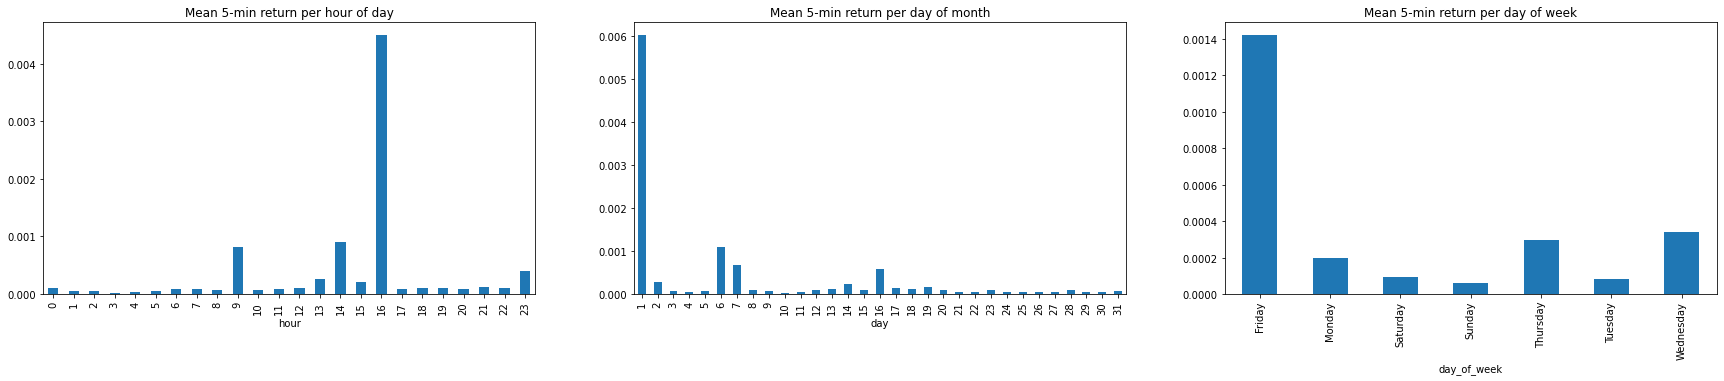

In [164]:
fig, axes = plt.subplots(1, 3, figsize=(30, 5))
df_cal.groupby("hour")["return"].mean().plot.bar(ax=axes[0], title="Mean 5-min return per hour of day");
df_cal.groupby("day_of_week")["return"].mean().plot.bar(ax=axes[2], title="Mean 5-min return per day of week");
df_cal.groupby("day")["return"].mean().plot.bar(ax=axes[1], title="Mean 5-min return per day of month");

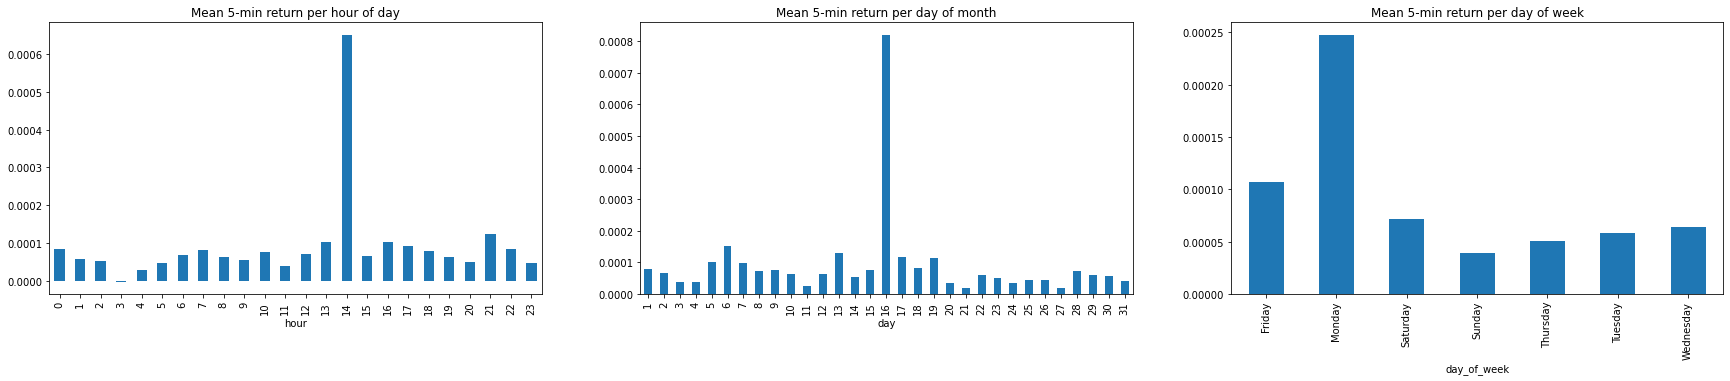

In [165]:
fig, axes = plt.subplots(1, 3, figsize=(30, 5))
df_cal[df_cal["datetime"].dt.year > 2018].groupby("hour")["return"].mean().plot.bar(ax=axes[0], title="Mean 5-min return per hour of day");
df_cal[df_cal["datetime"].dt.year > 2018].groupby("day_of_week")["return"].mean().plot.bar(ax=axes[2], title="Mean 5-min return per day of week");
df_cal[df_cal["datetime"].dt.year > 2018].groupby("day")["return"].mean().plot.bar(ax=axes[1], title="Mean 5-min return per day of month");

# First strategy: buy on friday morning, sell on friday evening

In [19]:
weights = strategy_trade_on_day(close, 4)
pnl_daily, pnl_total_daily, notional = compute_daily_pnl(weights, close)

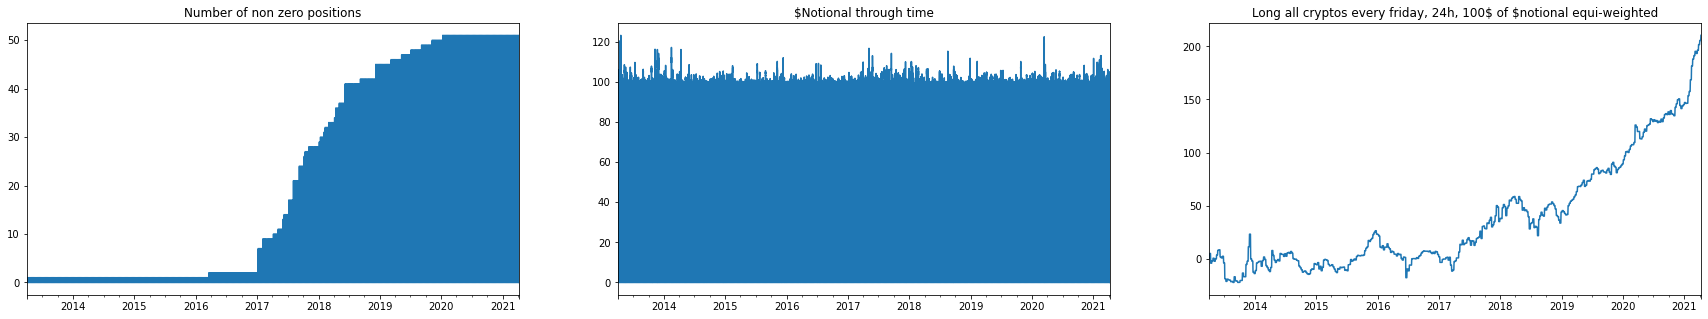

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(30, 5))
nbr_assets.plot(ax=axes[0], title="Number of non zero positions");
notional.sum(axis=1).plot(ax=axes[1], title="$Notional through time");
pnl_total_daily.plot(ax=axes[2], title="Long all cryptos every friday, 24h, 100\$ of \$notional equi-weighted");

In [6]:
account_curve_statistics(pnl_total_daily.loc["2017":])

Mean $Return      68.357533
Stddev $Return    36.401267
Sharpe             1.877889
dtype: float64

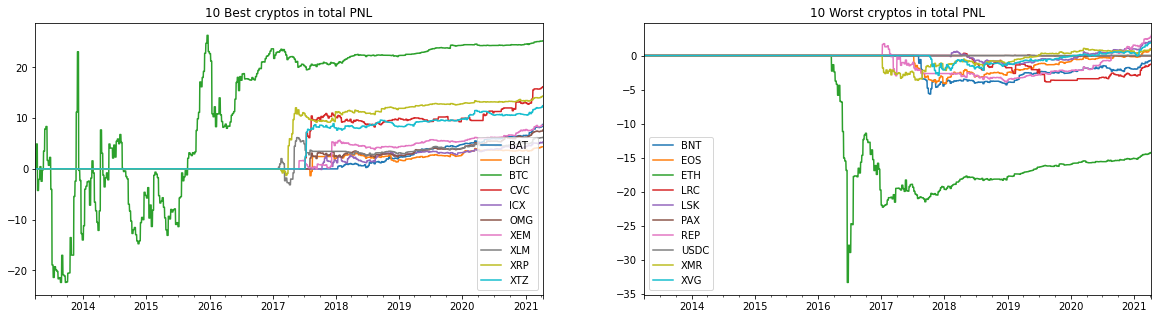

In [10]:
best_10_pnl = pnl_daily.sum().nlargest(10)
worst_10_pnl = pnl_daily.sum().nsmallest(10)

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
pnl_daily[[x for x in pnl.columns if x in best_10_pnl.index]].plot(ax=axes[0], title="10 Best cryptos in total PNL");
pnl_daily[[x for x in pnl.columns if x in worst_10_pnl.index]].plot(ax=axes[1], title="10 Worst cryptos in total PNL");

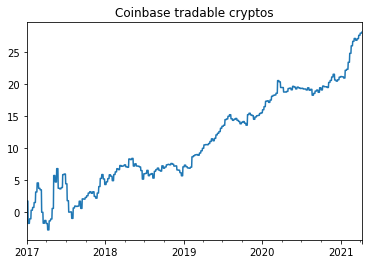

In [15]:
fig, axes = plt.subplots(1, 1)
pnl_daily[["BTC", "LTC", "ADA", "ETH", "LINK", "XLM", "BCH", "EOS", "XTZ", "ETC", "DAI", "MKR", "MANA", "BAT"]].sum(axis=1).loc["2017":].plot(title="Coinbase tradable cryptos");

# Trading only on each day

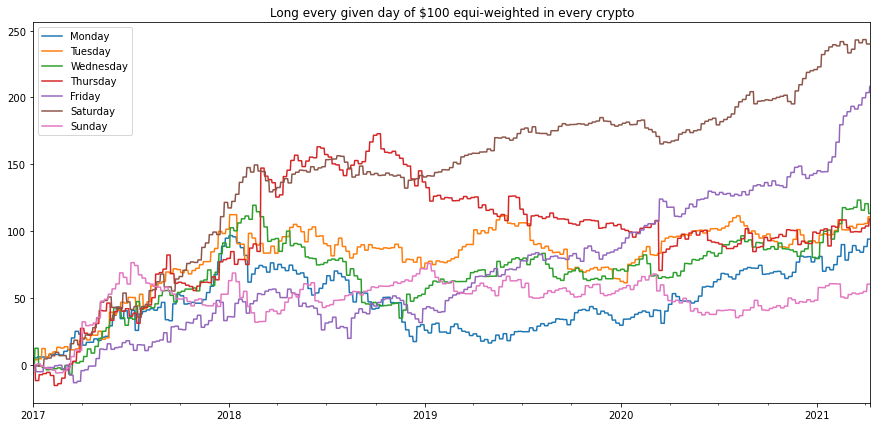

In [184]:
start_date = dt.datetime(2017, 1, 1)

res = {}
res["Monday"] = compute_daily_pnl(strategy_trade_on_day(close, 0, start_date=start_date), close)
res["Tuesday"] = compute_daily_pnl(strategy_trade_on_day(close, 1, start_date=start_date), close)
res["Wednesday"] = compute_daily_pnl(strategy_trade_on_day(close, 2, start_date=start_date), close)
res["Thursday"] = compute_daily_pnl(strategy_trade_on_day(close, 3, start_date=start_date), close)
res["Friday"] = compute_daily_pnl(strategy_trade_on_day(close, 4, start_date=start_date), close)
res["Saturday"] = compute_daily_pnl(strategy_trade_on_day(close, 5, start_date=start_date), close)
res["Sunday"] = compute_daily_pnl(strategy_trade_on_day(close, 6, start_date=start_date), close)

fig, axes = plt.subplots(1, 1, figsize=(15, 7))
for day, acc_curve in res.items():
    acc_curve[1].loc[start_date:].plot(ax=axes, label=day, title="Long every given day of $100 equi-weighted in every crypto");
axes.legend();

In [185]:
pd.DataFrame({day: account_curve_statistics(x[1].loc[start_date:]) for day, x in res.items()})

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Mean $Return,21.997658,25.893599,26.493874,25.525481,48.764398,56.110783,14.107993
Stddev $Return,34.393184,35.207998,36.046693,52.109578,30.798815,28.956540,29.953464
Sharpe,0.639594,0.735447,0.734988,0.489842,1.583321,1.937759,0.470997


# Holding friday and saturday

In [181]:
_, pnl_daily, _ = compute_daily_pnl(strategy_trade_on_day(close, [4, 5], start_date=start_date), close)

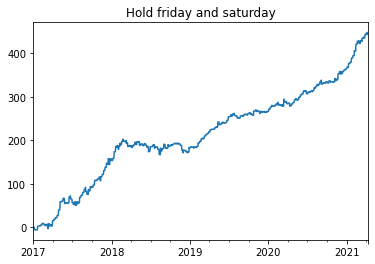

In [182]:
pnl_daily.loc[start_date:].plot(title="Hold friday and saturday");

In [183]:
account_curve_statistics(pnl_daily.loc[start_date:])

Mean $Return      104.875181
Stddev $Return     42.095673
Sharpe              2.491353
dtype: float64

# Friday saturday for Coinbase cryptos

In [175]:
_, pnl_daily, _ = compute_daily_pnl(strategy_trade_on_day(close, days=[4, 5], assets=COINBASE_CRYPTOS, start_date=start_date), close)

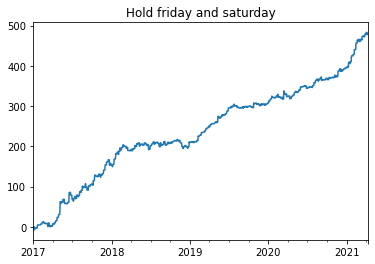

In [176]:
pnl_daily.loc[start_date:].plot(title="Hold friday and saturday");

In [177]:
account_curve_statistics(pnl_daily.loc[start_date:])

Mean $Return      112.771439
Stddev $Return     44.262780
Sharpe              2.547771
dtype: float64

# Friday saturday for Coinbase cryptos, vol adjusted

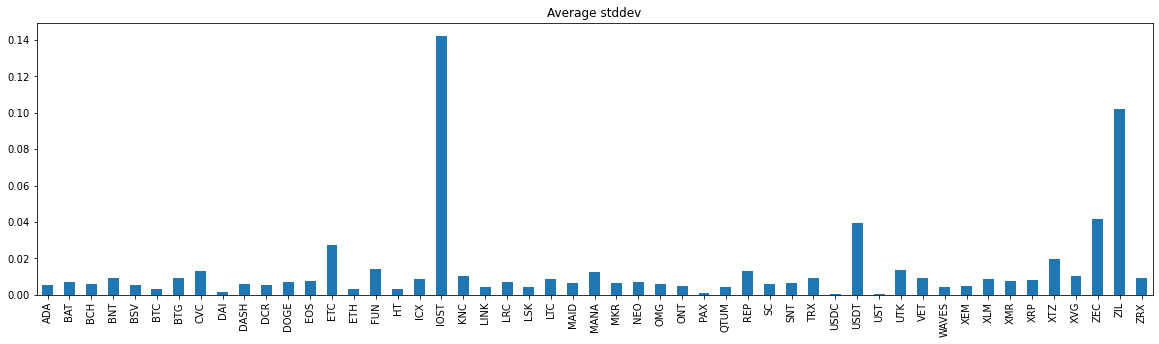

In [186]:
vol = close.pct_change().ewm(span=288 * 5).std() # 5 days
vol = vol.resample("D", label='right').last().reindex(vol.index, method="ffill")

fig, axes = plt.subplots(1, 1, figsize=(20, 5))
vol.mean().plot.bar(ax=axes);
axes.set_title("Average stddev");

In [187]:
_, pnl_daily, _ = compute_daily_pnl(strategy_trade_on_day(close, days=[4, 5], vol=vol, assets=COINBASE_CRYPTOS, start_date=start_date), close)

In [188]:
stats = {}
acc_curves = {}
for days in [1, 5, 10, 20, 40]:
    vol = close.pct_change().ewm(span=288 * days).std()
    vol = vol.resample("D", label='right').last().reindex(vol.index, method="ffill")
    _, pnl_daily, _ = compute_daily_pnl(strategy_trade_on_day(close, days=[4, 5], vol=vol, assets=COINBASE_CRYPTOS, start_date=start_date), close)
    pnl_daily = pnl_daily.loc[start_date:]
    acc_curves[days] = pnl_daily
    stats[days] = account_curve_statistics(pnl_daily)

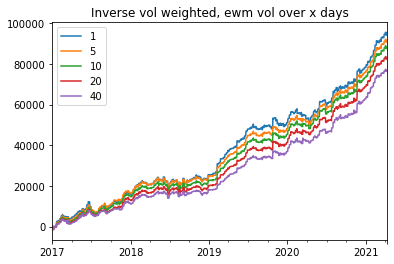

In [189]:
pd.DataFrame(acc_curves).plot(title="Inverse vol weighted, ewm vol over x days");

In [190]:
pd.DataFrame(stats)

,1,5,10,20,40
Mean $Return,22350.794809,21474.249493,20720.040343,19491.966227,18038.398988
Stddev $Return,9326.694554,8179.073944,7905.105095,7577.070273,7211.256307
Sharpe,2.396433,2.625511,2.621096,2.572494,2.501423


# Bps per trade

In [191]:
weights = strategy_trade_on_day(close, days=[4, 5], assets=COINBASE_CRYPTOS, start_date=start_date)
pnl_daily, pnl_daily_total, notional = compute_daily_pnl(weights, close)

<AxesSubplot:>

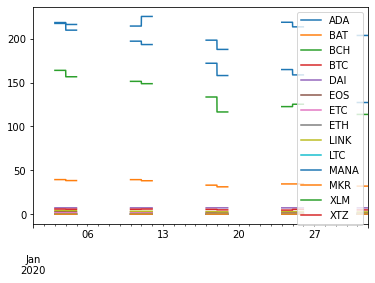

In [192]:
weights.loc["2020-01"].plot()

In [201]:
trades = weights.fillna(0.0).diff().fillna(0.0)
notional_traded = (trades * close).resample("D").sum().abs().cumsum()
bps_per_trade = pnl_daily / notional_traded * 10000

In [235]:
bps_per_trade.iloc[-1].dropna().sort_values(ascending=False)

MANA    220.832826
XTZ     153.340581
BAT     152.767901
LINK    138.943353
XLM     137.904283
LTC     127.423912
MKR     112.744059
ADA      97.042659
ETH      90.697025
BCH      83.045074
EOS      74.546370
ETC      65.863446
BTC      40.804976
DAI      -0.751498
Name: 2021-04-10 00:00:00, dtype: float64